# Contenido
* [Casos totales](#1.)
* [Nuevos casos](#2.)

In [19]:
import pandas as pd
from pandas.plotting import register_matplotlib_converters

import numpy as np
import datetime
import os
import sys

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import PercentFormatter
register_matplotlib_converters()

from scipy.optimize import curve_fit
from datetime import timedelta
from datetime import datetime
from io import StringIO
from urllib import request as url_request

In [20]:
days_past = -2 # days beyond the start of the data to plot
days_future = 20 # days after the end of the data to predict and plot

myFmt = mdates.DateFormatter('%d/%m') # date formatter for matplotlib
show_every = 2 # int value that defines how often to show a date in the x axis.

coeff_std = 1.1 # coefficient that defines how many standard deviations to use
coeff_std_d = 0.4

In [21]:
## Code from https://github.com/LucaAngioloni/fit-COVID19
def logistic(x, L, k, x0, y0):
    """
    General Logistic function.

    Args:
        x    float or array-like, it represents the time
        L    float, the curve's maximum value
        k    float, the logistic growth rate or steepness of the curve.
        x0   float, the x-value of the sigmoid's midpoint
        y0   float, curve's shift in the y axis
    """
    y = L / (1 + np.exp(-k*(x-x0))) + y0
    return y


## Defining functions
#### Code from https://github.com/LucaAngioloni/fit-COVID19

In [22]:
## Code from https://github.com/LucaAngioloni/fit-COVID19
def logistic_derivative(x, L, k, x0):
    """
    General Gaussian like function (derivative of the logistic).

    Args:
        x    float or array-like, it represents the time
        L    float, the curve's integral (area under the curve)
        k    float, the logistic growth rate or steepness of the curve.
        x0   float, the x-value of the max value
    """
    y = k * L * (np.exp(-k*(x-x0))) / np.power(1 + np.exp(-k*(x-x0)), 2)
    return y

In [23]:
## Code from https://github.com/LucaAngioloni/fit-COVID19
def fit_curve(curve, ydata, title, ylabel, last_date, coeff_std):
    xdata = np.array(list(range(-len(ydata), 0))) + 1

    if curve.__name__ == 'logistic':
        p0=[20000, 0.5, 1, 0]
        bounds=([0, 0, -100, 0], [200000, 10, 100, 1])
        params_names = ['L', 'k', 'x0', 'y0']
    elif curve.__name__ == 'logistic_derivative':
        p0=[20000, 0.5, 1]
        bounds=([0, 0, -100], [200000, 10, 100])
        params_names = ['L', 'k', 'x0']
    else:
        print('this curve is unknown')
        return -1

    popt, pcov = curve_fit(curve, xdata, ydata, p0=p0, bounds=bounds)

    descr = 'Fit parameters: '
    
    for i, param in enumerate(params_names):
        descr = descr + "{}={:.3f}".format(param, popt[i])
        if i < len(params_names) - 1:
            descr = descr + ', '
    print(descr)

    perr = np.sqrt(np.diag(pcov))
    print(perr)

    pworst = popt + coeff_std*perr
    pbest = popt - coeff_std*perr

    fig, ax = plt.subplots(figsize=(15,8))
    
    ax.xaxis.set_major_formatter(myFmt)
    fig.autofmt_xdate()

    total_xaxis = np.array(list(range(-len(ydata) + days_past, days_future))) + 1

    date_xdata = [last_date + timedelta(days=int(i)) for i in xdata]
    date_total_xaxis = [last_date + timedelta(days=int(i)) for i in total_xaxis]

    future_axis = total_xaxis[len(ydata) - days_past:]
    date_future_axis = [last_date + timedelta(days=int(i)) for i in future_axis]
    
    start = (len(ydata) - days_past - 1) % show_every


    ax.plot(date_total_xaxis, curve(total_xaxis, *popt), 'r-', linewidth=6, label='fit')
    ax.bar(date_xdata, ydata, label='data')
    ax.fill_between(date_future_axis, curve(future_axis, *pbest), curve(future_axis, *pworst), 
        facecolor='red', alpha=0.2, label='std')
    
    ax.set_xticks(date_total_xaxis[start::show_every])
    ax.set_xlabel('Date')
    ax.set_ylabel(ylabel)
    ax.set_title(title + ' - ' + str(last_date.strftime("%d-%m-%Y")))
    ax.legend(loc='upper left')
    ax.grid(True)

    return popt, perr

## Reading data

In [24]:
data = pd.read_csv('../data/final_data/dataCOVID19_es.csv')
Spain = data.groupby('fecha', as_index=False).sum()

In [25]:
Confirmed=Spain.casos.values
Deaths=Spain.muertes.values
nuevos_casos = [np.nan]+list(Spain.casos.values[1:] - Spain.casos.values[:-1])

dates=pd.to_datetime(Spain.fecha.values)

last_date = datetime.strptime(Spain.fecha.values[-1], "%Y-%m-%d")

# Total confirmed cases <a class="anchor" id="1."></a>

Fit parameters: L=110593.488, k=0.238, x0=1.338, y0=0.000
[2.06436151e+04 1.67689320e-02 1.35551371e+00 3.47046248e+02]


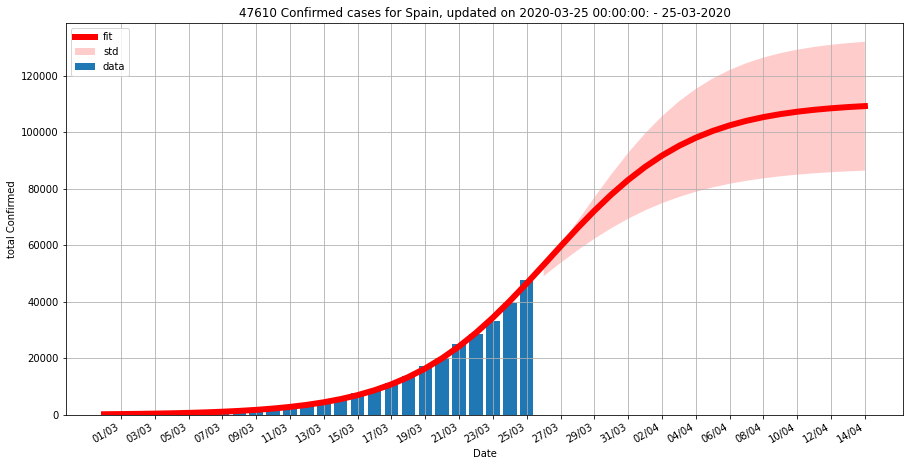

In [26]:
Titulo = '{:.0f} Confirmed cases for Spain, updated on {}:'.format(Confirmed[-1],dates[-1])
p_cont, err_cont = fit_curve(logistic, Confirmed, Titulo , 'total Confirmed', last_date, coeff_std);

Number of deaths 3434


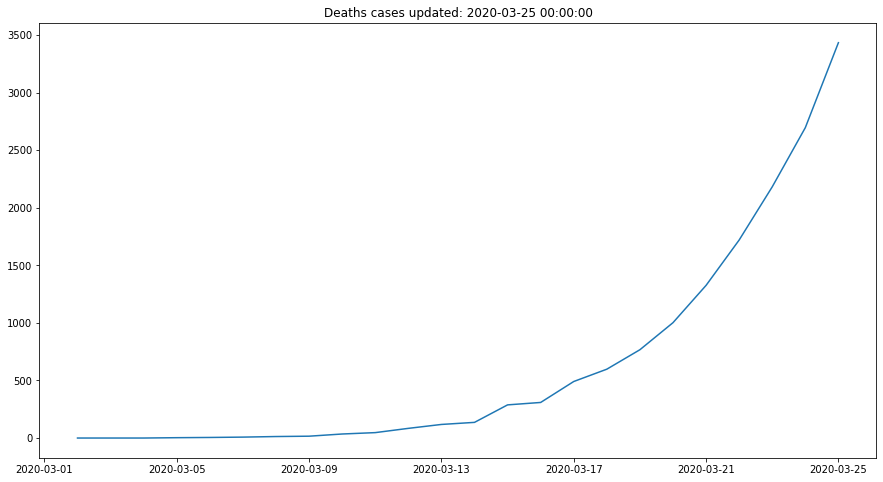

In [27]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(dates,Deaths)
ax.set_title("Deaths cases updated: {}".format(dates[-1]));
print('Number of deaths {:.0f}'.format(Deaths[-1]))

Fit parameters: L=11140.294, k=0.297, x0=2.759, y0=0.000
[1.88112381e+03 1.17303176e-02 8.95212969e-01 1.04858469e+01]


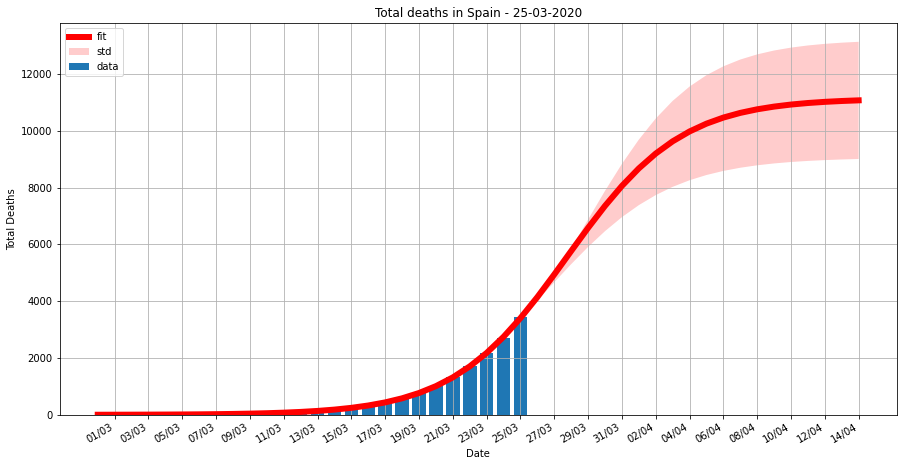

In [28]:
p_dead, err_dead = fit_curve(logistic, Deaths, 'Total deaths in Spain', 'Total Deaths', last_date, coeff_std)

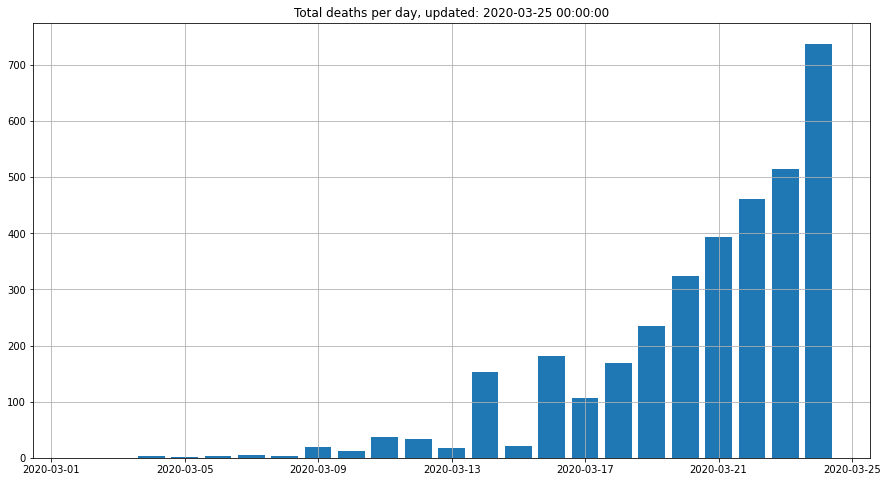

In [29]:
fig, ax = plt.subplots(figsize=(15,8))
ax.bar(dates[:-1],np.diff(Deaths))
ax.set_title("Total deaths per day, updated: {}".format(dates[-1]));
ax.grid()

Fit parameters: L=39101.952, k=0.246, x0=9.915
[7.66861210e+04 4.24743584e-02 1.01979720e+01]


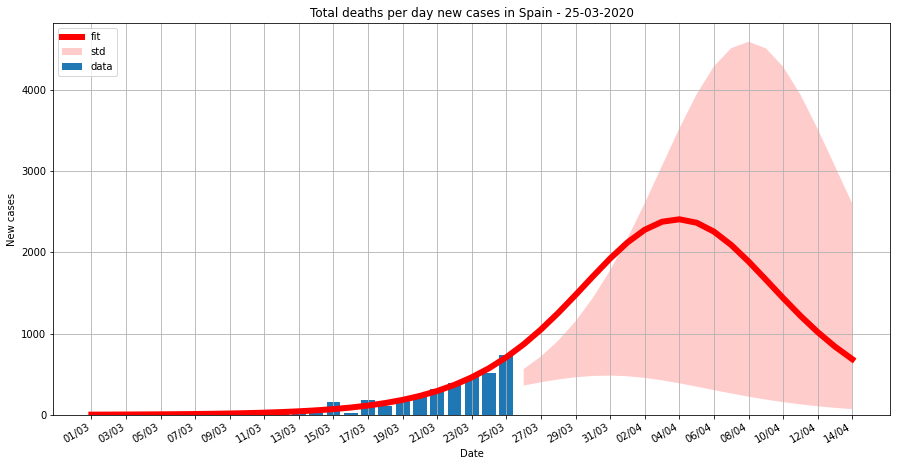

In [30]:
deathsPerDay=np.diff(Deaths)

Titulo = '{:.0f} deaths per day for Spain, updated on {}:'.format(deathsPerDay[-1],dates[-1])
fit_curve(logistic_derivative, deathsPerDay, 'Total deaths per day new cases in Spain', 'New cases', last_date, coeff_std_d);

# Nuevos casos <a class="anchor" id="2."></a>

## En toda España

Fit parameters: L=200000.000, k=0.208, x0=6.063
[1.35656637e+05 3.73432892e-02 5.08242865e+00]


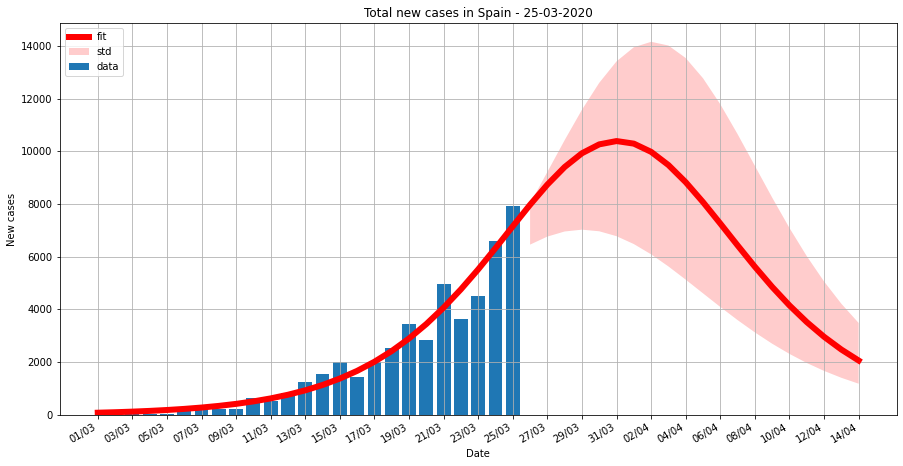

In [31]:
newCases=np.diff(Confirmed)

Titulo = '{:.0f} new cases for Spain, updated on {}:'.format(newCases[-1],dates[-1])
fit_curve(logistic_derivative, newCases, 'Total new cases in Spain', 'New cases', last_date, coeff_std_d);

In [32]:
tempVar=np.diff(Confirmed)
tempVar[tempVar==0]=np.nan
newCases=tempVar
datesNewCases=dates[1:]

In [33]:
growth_factor = newCases[1:] / newCases[:-1]
dates_growth_factor = datesNewCases[1:]

### Growth rates in Spain

In [34]:
print('Last growth factor: {:.3f}'.format(growth_factor[-1]))
print('Mean growth factor for the last 5 days: {:.3f}'.format(np.mean(growth_factor[-5:])))

Last growth factor: 1.205
Mean growth factor for the last 5 days: 1.277


### nuevos casos por CCAA ajustados a una logistic curve

Fit parameters: L=200000.000, k=0.186, x0=22.938
[4.61303832e+06 6.20042266e-02 1.33143043e+02]
Fit parameters: L=5774.974, k=0.203, x0=8.673
[9.43794226e+03 5.53206412e-02 1.14803890e+01]
Fit parameters: L=1608.256, k=0.224, x0=0.486
[8.33979521e+02 7.88574968e-02 4.09920770e+00]
Fit parameters: L=1054.449, k=0.313, x0=0.062
[2.97316962e+02 6.50265737e-02 1.60327503e+00]
Fit parameters: L=10000.255, k=0.204, x0=5.306
[1.16106927e+04 7.34609027e-02 9.10569575e+00]
Fit parameters: L=1968.443, k=0.218, x0=3.610
[7.32022560e+02 3.25145038e-02 2.85862755e+00]
Fit parameters: L=749.840, k=0.436, x0=-1.040
[1.17553428e+02 6.75239944e-02 6.24306988e-01]
Fit parameters: L=3927.024, k=0.362, x0=-1.565
[6.81451709e+02 6.43099404e-02 8.25097562e-01]
Fit parameters: L=7504.368, k=0.255, x0=2.059
[2.28733220e+03 3.89319055e-02 2.07408835e+00]
Fit parameters: L=200000.000, k=0.246, x0=12.496
[1.21374940e+06 7.09171078e-02 2.91423343e+01]
Fit parameters: L=185546.046, k=0.227, x0=44.149
[7.95669322e+

/Users/pvb/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in exp
  if sys.path[0] == '':
/Users/pvb/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


Fit parameters: L=200000.000, k=0.139, x0=18.358
[1.32548493e+06 7.22672944e-02 5.98994958e+01]
Fit parameters: L=199999.999, k=0.120, x0=71.186
[1.90343256e+09 2.35200228e-01 7.95165208e+04]
Fit parameters: L=11122.464, k=0.172, x0=18.296
[9.83793725e+04 6.64004284e-02 6.02174419e+01]
Fit parameters: L=4817.317, k=0.178, x0=6.333
[4.56140968e+03 5.01268286e-02 8.44750243e+00]
Fit parameters: L=23294.285, k=0.176, x0=10.641
[5.23426791e+04 5.92674319e-02 1.79079184e+01]


/Users/pvb/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in exp
  if sys.path[0] == '':
/Users/pvb/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


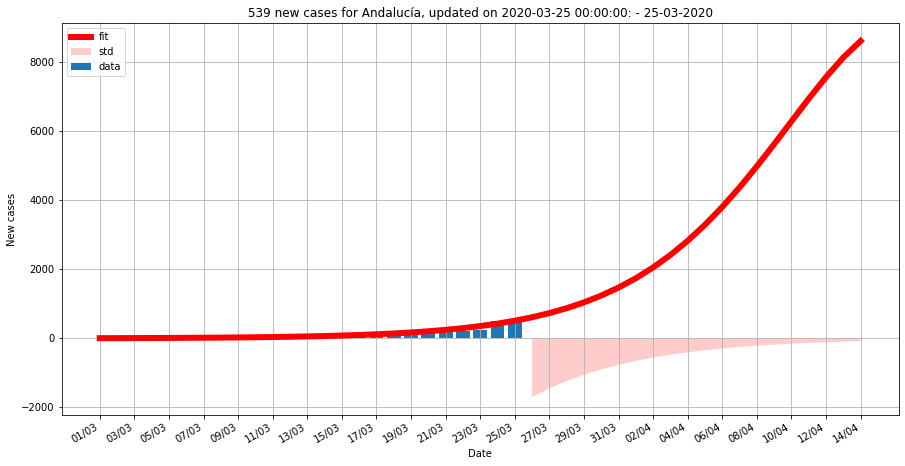

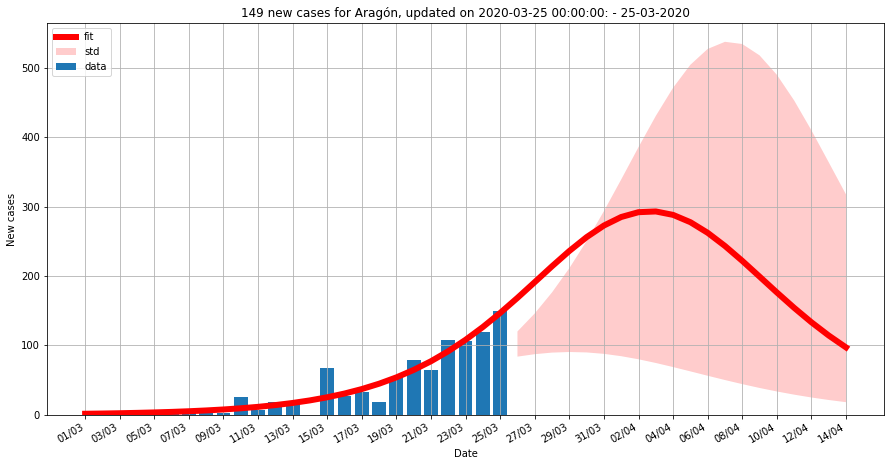

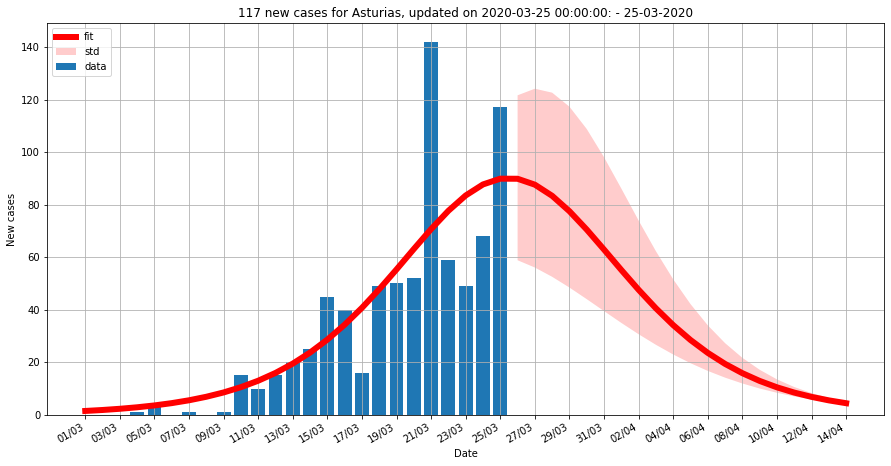

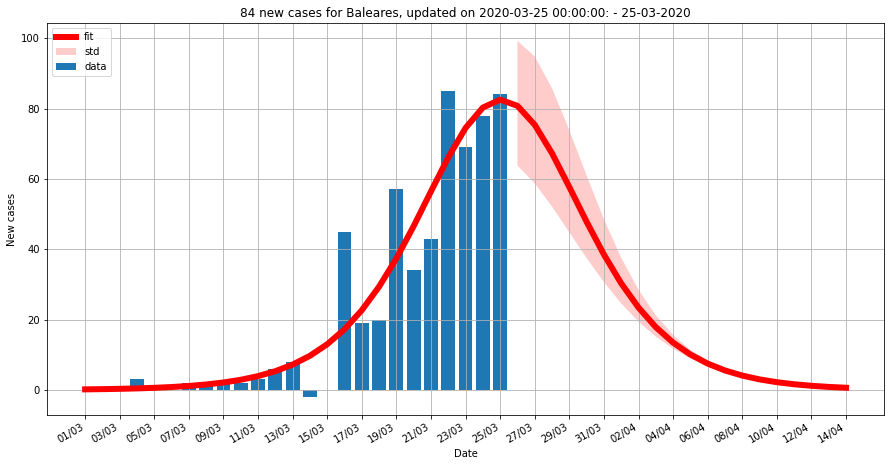

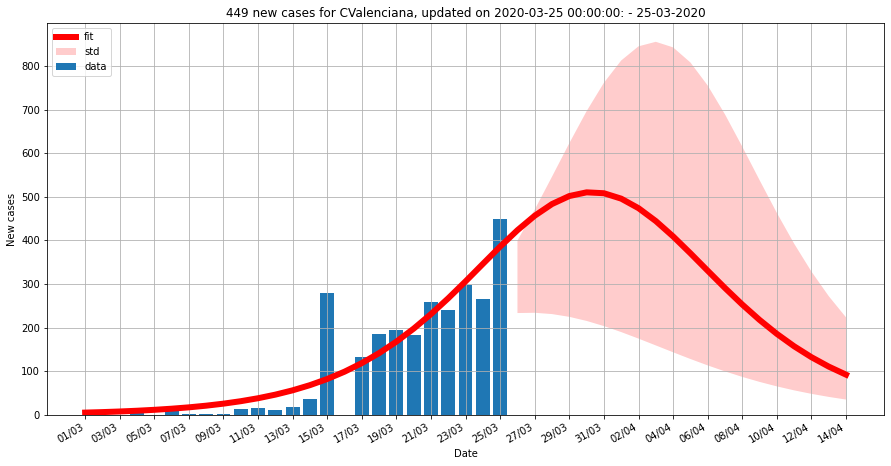

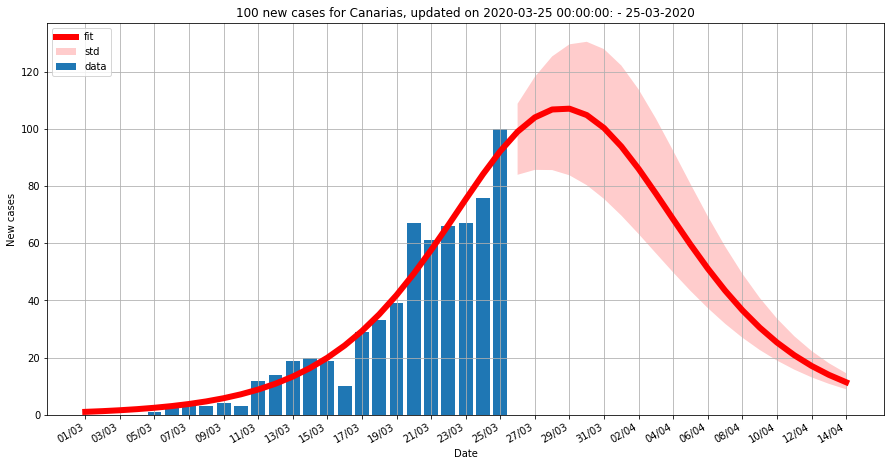

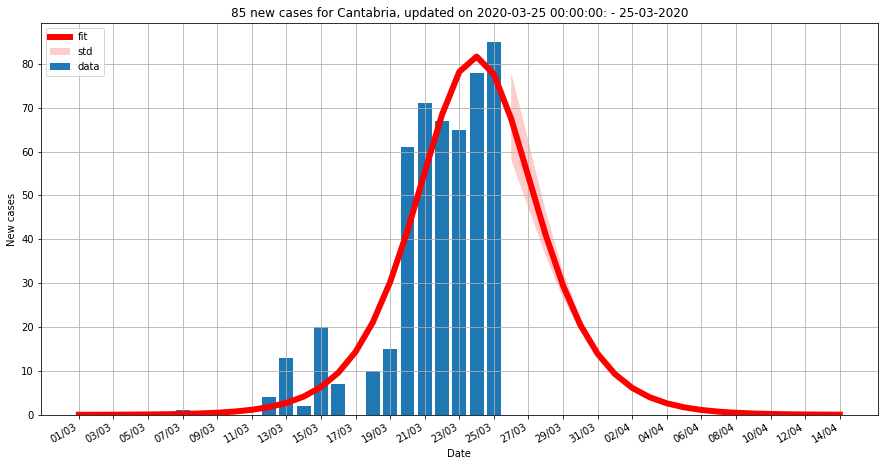

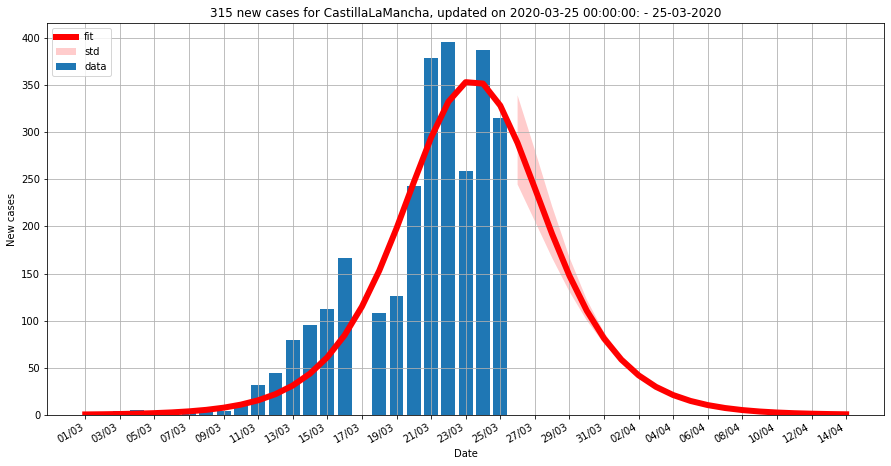

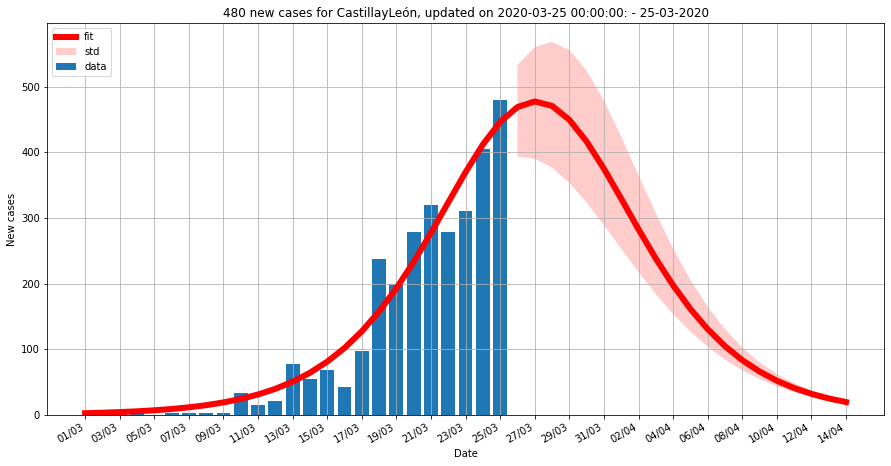

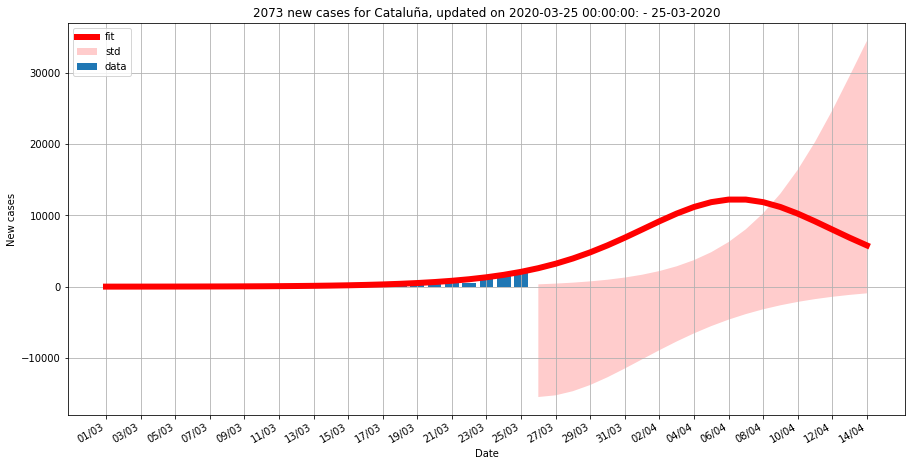

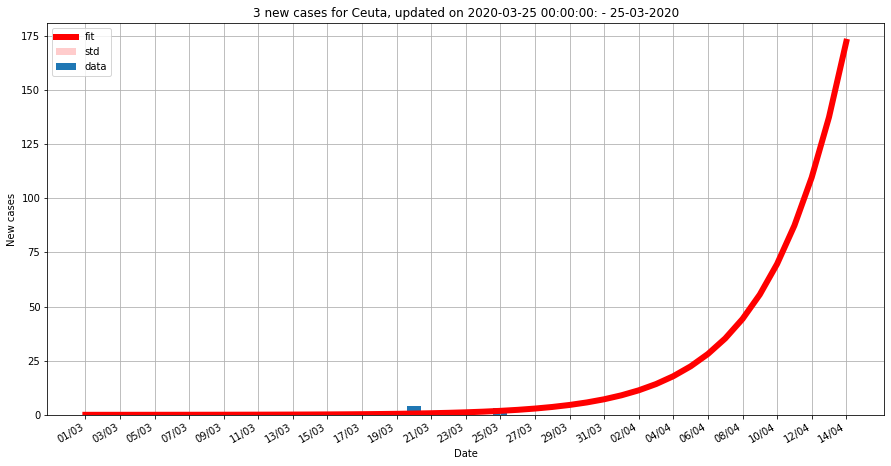

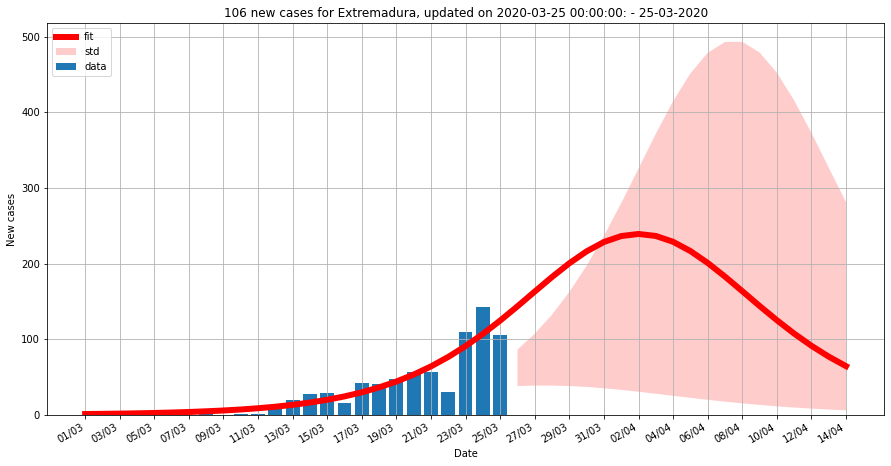

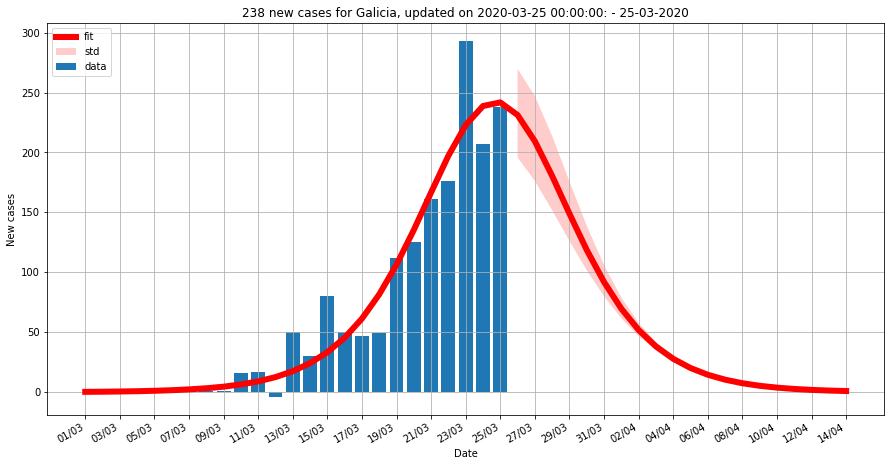

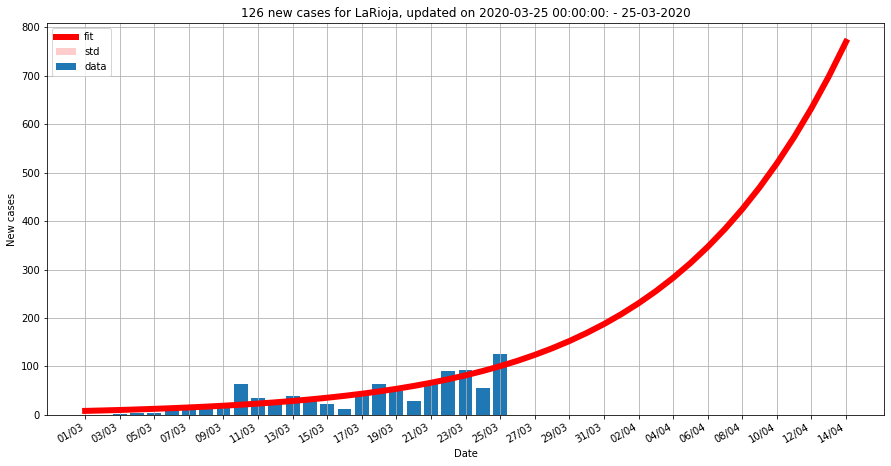

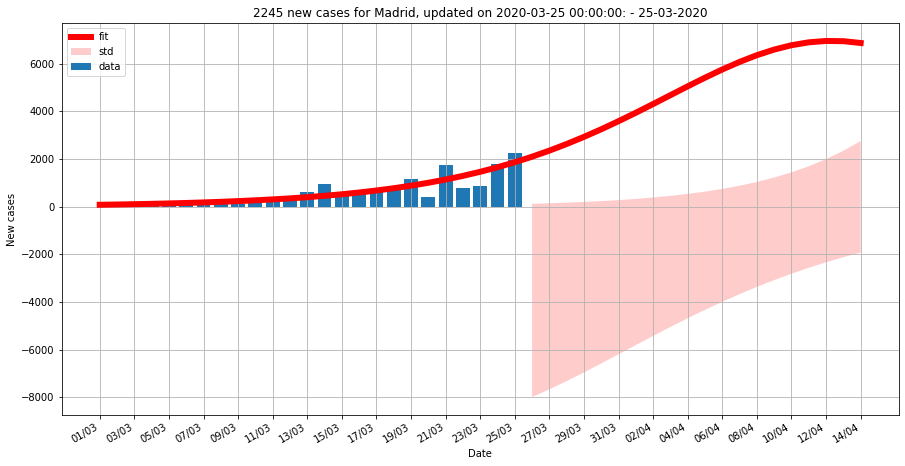

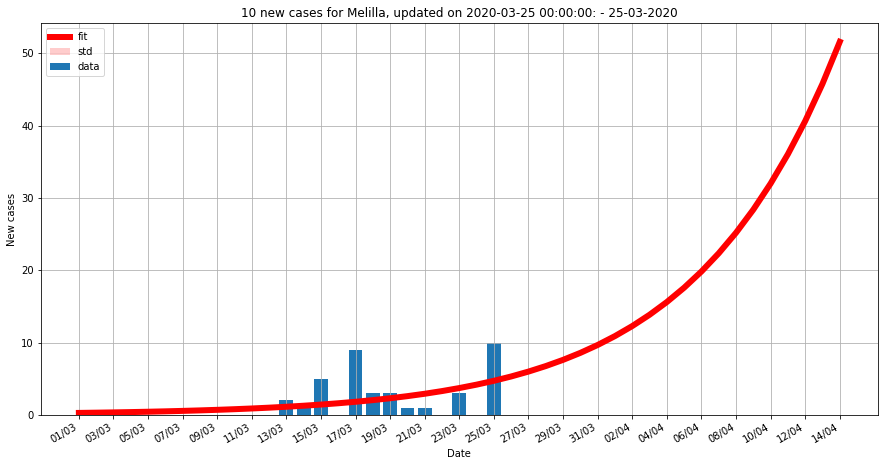

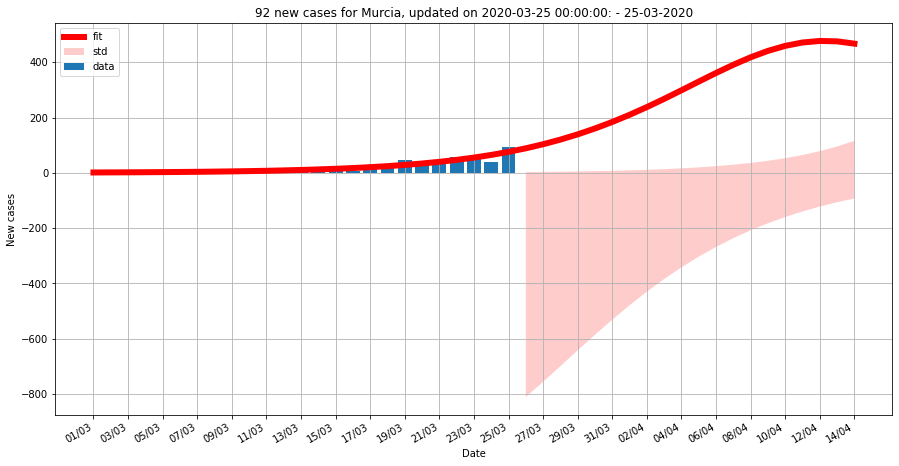

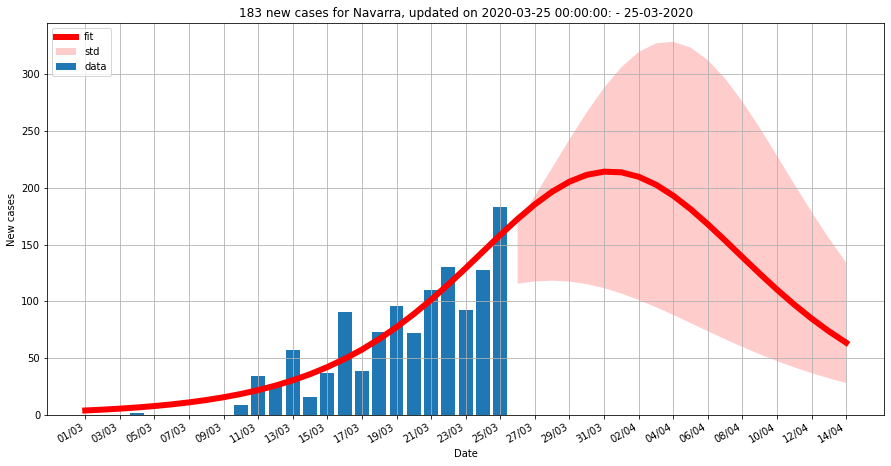

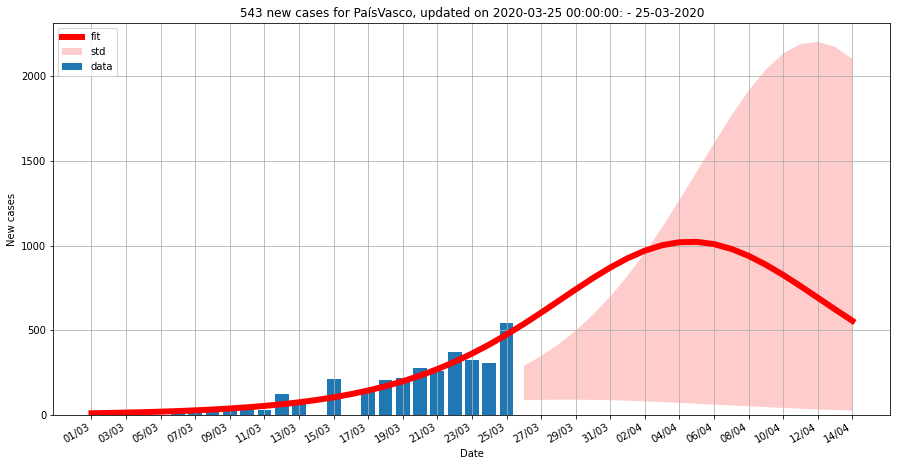

In [35]:
for CCAA in data.CCAA.unique():
    newCasesCCAA = np.diff(data[data.CCAA==CCAA].casos.values)
    Titulo = '{:.0f} new cases for {}, updated on {}:'.format(newCasesCCAA[-1],CCAA,dates[-1])
    fit_curve(logistic_derivative, newCasesCCAA, Titulo, 'New cases', last_date, coeff_std_d);